<a href="https://colab.research.google.com/github/sigopt/sigopt-examples/blob/main/metric-constraints-demo/GTSRB_preprocessing_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Colab Notebook goes through the data preprocessing and augmentation steps for the German Traffic Signs Dataset (GTSRB), as described in [this blog post](https://sigopt.com/blog/metric-constraints-demo/).

In [ ]:
from copy import deepcopy
import numpy
import pickle
import time

from skimage import exposure
from skimage.color import rgb2gray
from skimage.transform import ProjectiveTransform, rotate, warp
from skimage.morphology import disk
from skimage.filters import rank

import matplotlib.pyplot as plt
%matplotlib inline

Getting the pickled GTSRB data from [here](https://https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip).

In [ ]:
relative_path = "./drive/My Drive/Colab Notebooks/"
training_file = relative_path + "traffic-signs-data/train.p"
validation_file= relative_path + "traffic-signs-data/valid.p"
testing_file = relative_path + "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

In [ ]:
train.keys()

dict_keys(['coords', 'labels', 'features', 'sizes'])

In [ ]:
X_train = (train['features']/ 256).astype('float32')
y_train = train['labels']
X_valid = (valid['features'] / 256).astype('float32')
y_valid = valid['labels']
X_test = (test['features'] / 256).astype('float32')
y_test = test['labels']

n_train = X_train.shape[0]
n_test = X_test.shape[0]
n_validation = X_valid.shape[0]

image_shape = X_train[0].shape
assert image_shape == X_valid[0].shape == X_test[0].shape
classes, class_start_indices, class_counts = numpy.unique(y_train, return_index=True, return_counts=True)
n_classes = len(classes)
assert n_classes == len(numpy.unique(y_valid))

print(f'Num of training set: {n_train}')
print(f'Num of validation set: {n_validation}')
print(f'Num of test set: {n_test}')
print(f'Image data shape = {image_shape}')
print(f'Number of classes = {n_classes}')

Num of training set: 34799
Num of validation set: 4410
Num of test set: 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [ ]:
NUM_CLASSES = 43
IMG_SIZE = 32

Preview the traffic signs by classes

class 0: 180 samples


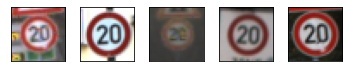

class 1: 1980 samples


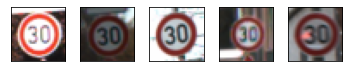

class 2: 2010 samples


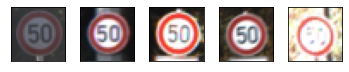

class 3: 1260 samples


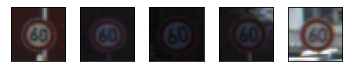

class 4: 1770 samples


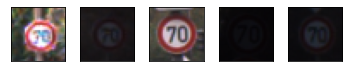

class 5: 1650 samples


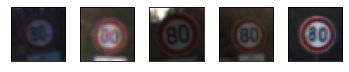

class 6: 360 samples


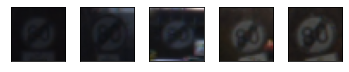

class 7: 1290 samples


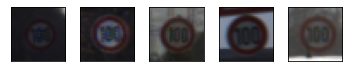

class 8: 1260 samples


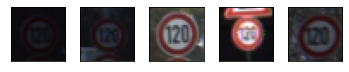

class 9: 1320 samples


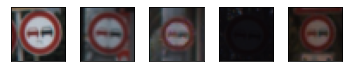

class 10: 1800 samples


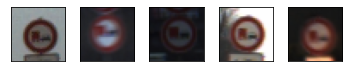

class 11: 1170 samples


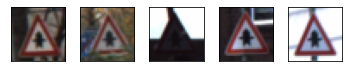

class 12: 1890 samples


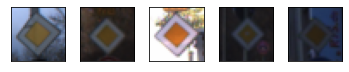

class 13: 1920 samples


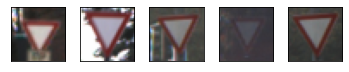

class 14: 690 samples


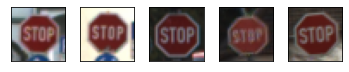

class 15: 540 samples


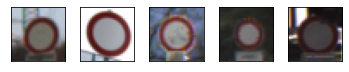

class 16: 360 samples


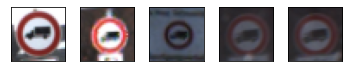

class 17: 990 samples


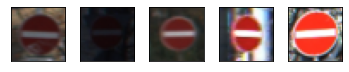

class 18: 1080 samples


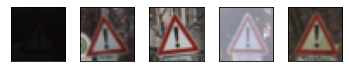

class 19: 180 samples


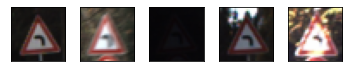

class 20: 300 samples


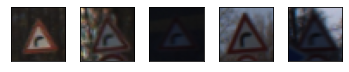

class 21: 270 samples


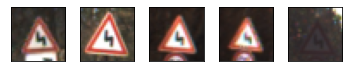

class 22: 330 samples


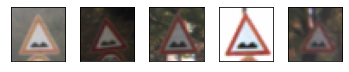

class 23: 450 samples


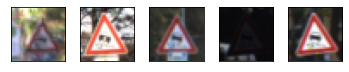

class 24: 240 samples


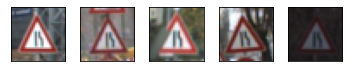

class 25: 1350 samples


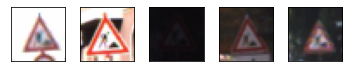

class 26: 540 samples


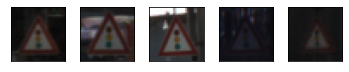

class 27: 210 samples


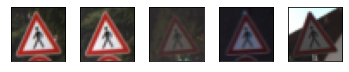

class 28: 480 samples


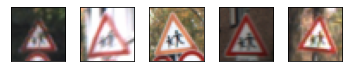

class 29: 240 samples


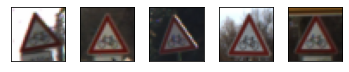

class 30: 390 samples


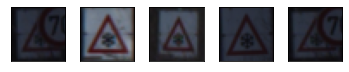

class 31: 690 samples


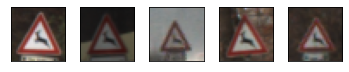

class 32: 210 samples


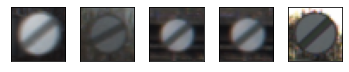

class 33: 599 samples


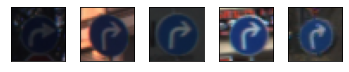

class 34: 360 samples


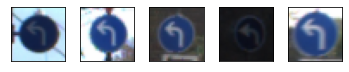

class 35: 1080 samples


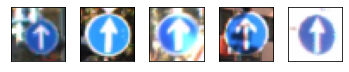

class 36: 330 samples


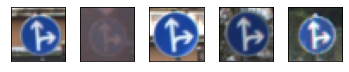

class 37: 180 samples


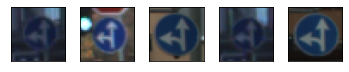

class 38: 1860 samples


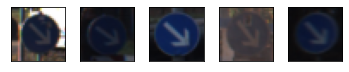

class 39: 270 samples


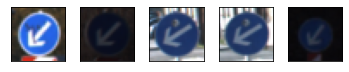

class 40: 300 samples


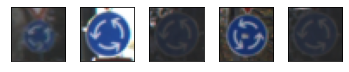

class 41: 210 samples


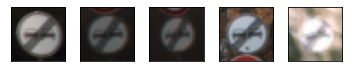

class 42: 210 samples


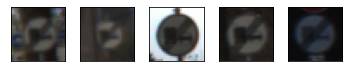

In [ ]:
preview_num = 5
for c, c_index, c_count in zip(classes, class_start_indices, class_counts):
  print(f'class {c}: {c_count} samples')
  fig, axes = plt.subplots(1, preview_num, figsize=(6, 1))
  selected_imgs = numpy.random.randint(c_index, c_index + c_count, preview_num)
  for i in range(preview_num):
    axes[i].imshow(X_train[selected_imgs[i]])
    axes[i].set_xticks([])
    axes[i].set_yticks([])
  plt.show()

Plot the class distribution

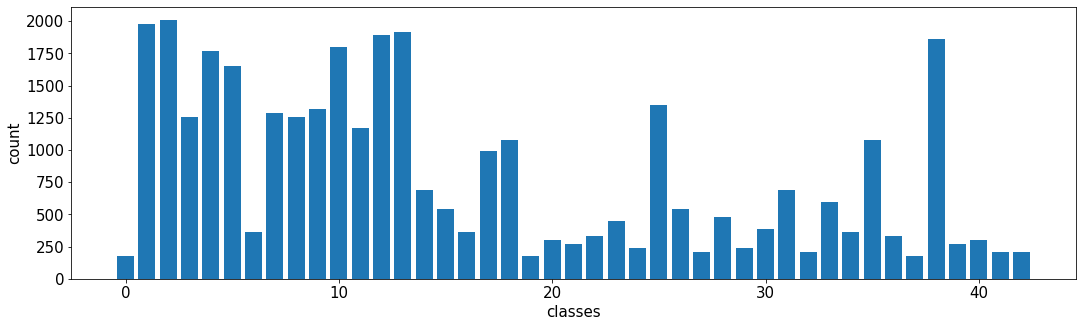

In [ ]:
FONTSIZE = 15
plt.figure(figsize=(18, 5))
plt.bar(classes, class_counts)
plt.xlabel('classes', fontsize=FONTSIZE)
plt.ylabel('count', fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)

plt.savefig('class_dist_before.png', transparent=True, bbox_inches='tight')
plt.show()

Consider some preprocessing functions: grayscale, histogram equalization, local histogram equalization, etc. The micronnet paper uses all three channels, will only consider histogram equalization for this example.

In [ ]:
def convert_to_grayscale(rgb_img):
  assert len(rgb_img.shape) == 3
  return rgb2gray(rgb_img)

def equalize_histogram(img):
  return exposure.equalize_hist(img) 

def local_equalize_histogram(img):
  selem = disk(30)
  return rank.equalize(img, selem=selem)

/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.6/dist-packages/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)


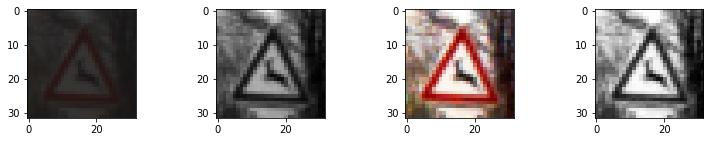

In [ ]:
preview_img = X_train[235]
fig, axes = plt.subplots(1, 4, figsize=(13, 2))
axes[0].imshow(preview_img, cmap='gray')
axes[1].imshow(convert_to_grayscale(preview_img), cmap='gray')
axes[2].imshow(equalize_histogram(preview_img), cmap='gray')
axes[3].imshow(local_equalize_histogram(convert_to_grayscale(preview_img)), cmap='gray')
plt.show()

Data Augmentation Step 1:

Some sign classes have self vertical or horizontal symmtry (e.g., arrows, warning, etc.), some classes have pairwise symmtry (e.g., right turn and left turn signs). We use these properties to increase the training data samples first.

In [ ]:
VERTICAL_INVARIANT_CLASSES = numpy.array([11, 12, 13, 15, 17, 18, 22, 26, 30, 35])
HORIZONTAL_INVARIANT_CLASSES = numpy.array([1, 5, 12, 15, 17])
VERTICAL_HORIZONTAL_INVARIANT_CLASSES = numpy.array([32, 40])
PAIRWISE_REFLECTION_CLASSES = numpy.array([[19, 20], [33, 34], [36, 37], [38, 39]])

In [ ]:
# Flipping the signs vertically or/and horizontally to extend the number of samples
def simple_augmentation(X, y):
  assert len(X.shape) == 4
  assert len(numpy.unique(y)) == NUM_CLASSES
  
  def horizontal_flip(X):
    return X[:, :, ::-1, :]

  def vertical_flip(X):
    return X[:, ::-1, :, :]

  def vertical_horizontal_flip(X):
    return X[:, ::-1, ::-1, :]

  X_extended = numpy.empty([0, X.shape[1], X.shape[2], X.shape[3]], dtype = X.dtype)
  y_extended = numpy.empty([0], dtype = y.dtype)
  
  for c in range(NUM_CLASSES):
    X_class = X[y == c]
    y_class = y[y == c]
    class_size = len(y_class)

    X_extended = numpy.append(X_extended, X_class, axis=0)
    y_extended = numpy.append(y_extended, y_class)

    if c in VERTICAL_INVARIANT_CLASSES:
      X_extended = numpy.append(X_extended, vertical_flip(X[y == c]), axis=0)
      y_extended = numpy.append(y_extended, numpy.full(class_size, c))
    elif c in HORIZONTAL_INVARIANT_CLASSES:
      X_extended = numpy.append(X_extended, horizontal_flip(X[y == c]), axis=0)
      y_extended = numpy.append(y_extended, numpy.full(class_size, c))
    elif c in VERTICAL_HORIZONTAL_INVARIANT_CLASSES:
      X_extended = numpy.append(X_extended, vertical_horizontal_flip(X[y == c]), axis=0)
      y_extended = numpy.append(y_extended, numpy.full(class_size, c))
    elif c in PAIRWISE_REFLECTION_CLASSES[:, 0]:
      other_class = PAIRWISE_REFLECTION_CLASSES[PAIRWISE_REFLECTION_CLASSES[:, 0] == c, 1][0]
      other_size = len(y[y == other_class])
      X_extended = numpy.append(X_extended, horizontal_flip(X[y == c]), axis=0)
      y_extended = numpy.append(y_extended, numpy.full(class_size, other_class))
      X_extended = numpy.append(X_extended, horizontal_flip(X[y == other_class]), axis=0)
      y_extended = numpy.append(y_extended, numpy.full(other_size, c))
    
  return X_extended, y_extended

In [ ]:
X_train_extend, y_train_extend = simple_augmentation(X_train, y_train)

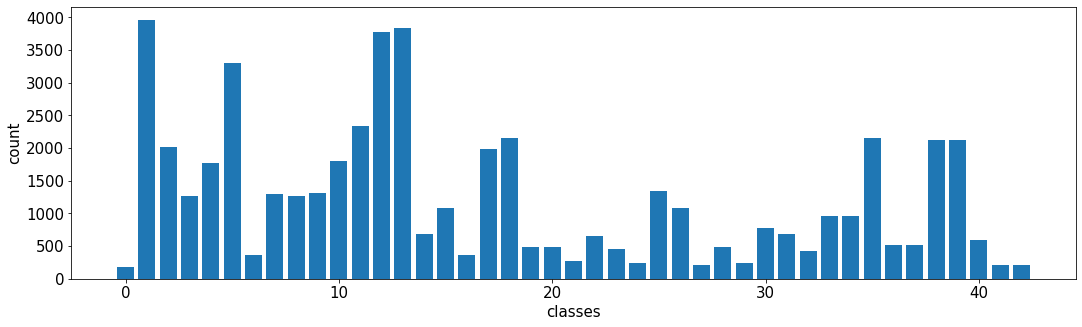

In [ ]:
classes, class_counts = numpy.unique(y_train_extend, return_counts=True)
n_classes = len(classes)

plt.figure(figsize=(18, 5))
plt.bar(classes, class_counts)
plt.xlabel('classes', fontsize=FONTSIZE)
plt.ylabel('count', fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)

# plt.savefig('class_dist_after.png', transparent=True, bbox_inches='tight')
plt.show()

Data Augmentation Step 2:

Apply [projection transformation](https://en.wikipedia.org/wiki/Homography) to under-represneted classes to augment the training samples.

In [ ]:
# Need to make sure images in X are in [0, 1] instead of [0, 255] intensity
def apply_projection_transform(X, multiplier=0.2):
  pixel = IMG_SIZE * multiplier
  Y = numpy.empty_like(X, dtype=X.dtype)    
  for i in range(len(X)):
    random_pixels = numpy.random.uniform(low=-pixel, high=pixel, size=8)
    top_left_x = random_pixels[0]
    top_left_y = random_pixels[1]
    bottom_left_x = random_pixels[2]
    bottom_left_y = IMG_SIZE + random_pixels[3]
    top_right_x = IMG_SIZE + random_pixels[4]
    top_right_y = random_pixels[5]
    bottom_right_x = IMG_SIZE + random_pixels[6]
    bottom_right_y = IMG_SIZE + random_pixels[7]

    picked_corners = numpy.array([
      [top_left_x, top_left_y], 
      [bottom_left_x, bottom_left_y], 
      [top_right_x, top_right_y], 
      [bottom_right_x, bottom_right_y]
    ])
    img_corners = numpy.array([[0, 0], [0, IMG_SIZE], [IMG_SIZE, 0], [IMG_SIZE, IMG_SIZE]])
    transform = ProjectiveTransform()
    transform.estimate(img_corners, picked_corners)
    Y[i] = warp(X[i], transform, output_shape=(IMG_SIZE, IMG_SIZE), order=1, mode='edge')

  return Y

before


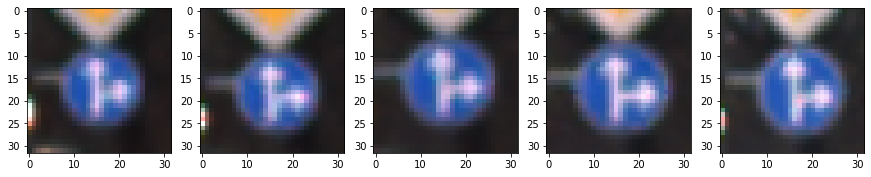

after: 0.23


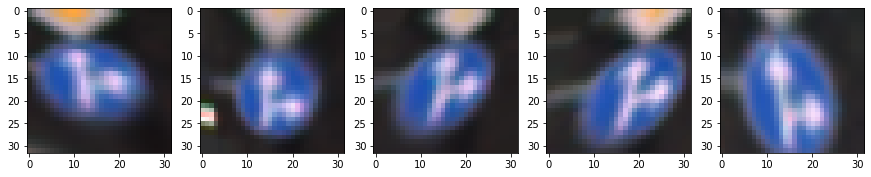

after: 0.32


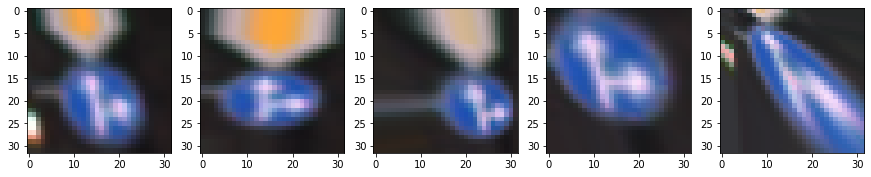

In [ ]:
X_try = deepcopy(X_train[1200:1205])
print('before')
fig, axes = plt.subplots(1, len(X_try), figsize=(15, 5))
for i, x in enumerate(X_try):
  axes[i].imshow(x)
plt.show()

projected_X = apply_projection_transform(X_try, 0.23)
print('after: 0.23')
fig, axes = plt.subplots(1, len(X_try), figsize=(15, 5))
for i, x in enumerate(projected_X):
  axes[i].imshow(x)
plt.show()

projected_X = apply_projection_transform(X_try, 0.32)
print('after: 0.32')
fig, axes = plt.subplots(1, len(X_try), figsize=(15, 5))
for i, x in enumerate(projected_X):
  axes[i].imshow(x)
plt.show()

In [ ]:
max(class_counts)

3960

In [ ]:
# Append under-represented classes with augmented examples
def transform_augmentation(X, y, max_size, level):
  X_extended = numpy.empty([0, X.shape[1], X.shape[2], X.shape[3]], dtype = X.dtype)
  y_extended = numpy.empty([0], dtype = y.dtype)

  for c in range(NUM_CLASSES):
    X_class = X[y == c]
    y_class = y[y == c]
    class_size = len(y_class)
    print(f'class {c} has {class_size} samples')

    X_extended = numpy.append(X_extended, X_class, axis=0)
    y_extended = numpy.append(y_extended, y_class)

    X_aug = numpy.empty([0, X.shape[1], X.shape[2], X.shape[3]], dtype=X.dtype)
    y_aug = numpy.empty([0], dtype=y.dtype)
    
    running_size = class_size
    while running_size < level * max_size:
      X_aug = numpy.append(X_aug, apply_projection_transform(X_class, multiplier=0.2), axis=0)
      y_aug = numpy.append(y_aug, y_class)
      running_size += class_size
      print(f'class {c} has {running_size} samples')
  
    X_extended = numpy.append(X_extended, X_aug, axis=0)
    y_extended = numpy.append(y_extended, y_aug)
    
  return X_extended, y_extended

In [ ]:
# X_train_he = numpy.array(list(map(equalize_histogram, X_train)))
X_train_extend, y_train_extend = simple_augmentation(X_train, y_train)
X_train_full, y_train_full = transform_augmentation(X_train_extend, y_train_extend, max_size=3960, level=0.7)

class 0 has 180 samples
class 0 has 360 samples
class 0 has 540 samples
class 0 has 720 samples
class 0 has 900 samples
class 0 has 1080 samples
class 0 has 1260 samples
class 0 has 1440 samples
class 0 has 1620 samples
class 0 has 1800 samples
class 0 has 1980 samples
class 0 has 2160 samples
class 0 has 2340 samples
class 0 has 2520 samples
class 0 has 2700 samples
class 0 has 2880 samples
class 1 has 3960 samples
class 2 has 2010 samples
class 2 has 4020 samples
class 3 has 1260 samples
class 3 has 2520 samples
class 3 has 3780 samples
class 4 has 1770 samples
class 4 has 3540 samples
class 5 has 3300 samples
class 6 has 360 samples
class 6 has 720 samples
class 6 has 1080 samples
class 6 has 1440 samples
class 6 has 1800 samples
class 6 has 2160 samples
class 6 has 2520 samples
class 6 has 2880 samples
class 7 has 1290 samples
class 7 has 2580 samples
class 7 has 3870 samples
class 8 has 1260 samples
class 8 has 2520 samples
class 8 has 3780 samples
class 9 has 1320 samples
class 9

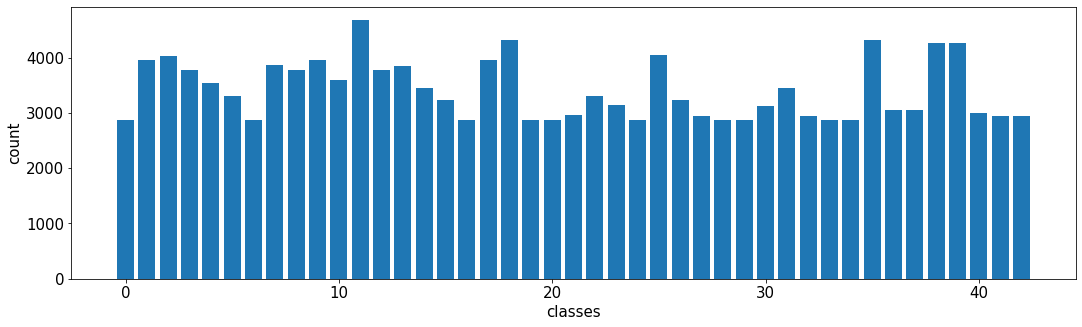

In [ ]:
classes, class_counts = numpy.unique(numpy.sort(y_train_full), return_counts=True)
n_classes = len(classes)

plt.figure(figsize=(18, 5))
plt.bar(classes, class_counts)
plt.xlabel('classes', fontsize=FONTSIZE)
plt.ylabel('count', fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)

plt.savefig('class_dist_after.png', transparent=True, bbox_inches='tight')
plt.show()

In [ ]:
len(y_train_full)

146874

In [ ]:
pp_train_data = dict(
  features=X_train_full,
  labels=y_train_full,
)
pickle.dump(pp_train_data, open(relative_path + "traffic-signs-data/train_extended.p", "wb"))